# Estudio Comparativo: Machine Learning Clásico vs Cuántico
## Clasificación de Sonidos Respiratorios (EPOC vs Sano)

---

**Autor:** Alejandro Moris Lara  
**Asignatura:** Temas Avanzados de Ciencia e Ingeniería de Datos  
**Fecha:** Diciembre 2024

---

### Resumen

Este notebook presenta un estudio comparativo riguroso entre modelos de Machine Learning clásico y cuántico para la clasificación binaria de sonidos respiratorios (EPOC vs Sano). Se comparan cuatro arquitecturas: SVM clásico (baseline), QSVM (kernel cuántico), VQC (clasificador variacional cuántico) y un modelo híbrido cuántico-clásico.

**Modelos evaluados:**
- **SVM Clásico:** Baseline con kernel RBF y pesos de clase balanceados.
- **QSVM:** SVM con kernel cuántico precomputado.
- **VQC:** Clasificador variacional con circuito parametrizado.
- **Híbrido:** Red neuronal clásica + capa cuántica.

**Métricas principales:**
- Balanced Accuracy (precisión balanceada)
- F1-Score de la clase minoritaria
- PR-AUC (Precision-Recall AUC)
- Recall de la clase minoritaria (Healthy)
- ROC-AUC

**Limitaciones cuánticas:**
- Los simuladores cuánticos escalan exponencialmente con el número de qubits.
- Reducción dimensional obligatoria: 52 features → 8 componentes PCA (= 8 qubits).
- El cálculo del kernel cuántico escala O(N²), limitando el tamaño de entrenamiento.
- Los modelos cuánticos se evalúan sobre un subconjunto por viabilidad computacional.


## 1. Introducción

### 1.1 Contexto del problema

La Enfermedad Pulmonar Obstructiva Crónica (EPOC) representa una de las principales causas de morbilidad y mortalidad a nivel mundial. El diagnóstico temprano mediante auscultación pulmonar es subjetivo y depende de la experiencia del médico. La automatización de este proceso mediante Machine Learning puede mejorar la accesibilidad y consistencia del diagnóstico.

### 1.2 Motivación

La computación cuántica promete ventajas teóricas en espacios de características de alta dimensionalidad gracias a la expansión exponencial del espacio de Hilbert. Este estudio busca evaluar empíricamente si los modelos cuánticos (simulados) ofrecen ventajas prácticas sobre los clásicos en un problema real de clasificación médica.

### 1.3 Hipótesis

Esperamos que el modelo clásico SVM (con kernel RBF optimizado) establezca un baseline competitivo difícil de superar. Los modelos cuánticos, debido a las limitaciones de simulación (reducción dimensional, muestras limitadas), probablemente no superarán al clásico, pero permitirán entender el potencial y los retos del QML aplicado.

### 1.4 Principales retos

1. **Desbalanceo severo:** El dataset tiene una proporción aproximada de 18:1 (EPOC:Healthy). Esto requiere tratamiento explícito mediante pesos de clase, métricas robustas y posible ajuste de umbral.

2. **Correlación por paciente:** Múltiples ciclos respiratorios provienen del mismo paciente. Sin split por paciente, habría data leakage, inflando artificialmente los resultados.

3. **Coste cuántico:** Los simuladores limitan el número de qubits viables (~8-10) y el tamaño de los conjuntos de entrenamiento para kernels cuánticos.


## 2. Dataset: Procedencia, Significado y Exploración

### 2.1 ICBHI Respiratory Sound Database

El dataset proviene del ICBHI 2017 Scientific Challenge. Contiene grabaciones de auscultación pulmonar de 126 pacientes con diferentes diagnósticos. Para este estudio, nos centramos en la clasificación binaria: **Healthy vs EPOC**.

**¿Qué representa una muestra?** Cada fila corresponde a un ciclo respiratorio individual extraído de las grabaciones de audio, del cual se han computado 52 características acústicas (MFCCs y sus derivadas).

**¿Qué significa la etiqueta?** La etiqueta indica el diagnóstico del paciente: 0 = Healthy (sano), 1 = COPD/EPOC.


In [1]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Add project root to path
import sys
sys.path.insert(0, str(Path.cwd().parent))

# Project imports
from config.settings import *
from config.paths import *
from src.features.extractor import AudioFeatureExtractor
from src.features.reducer import DimensionalityReducer, normalize_for_quantum
from src.data.splitter import PatientWiseSplitter
from src.models.classical import ClassicalSVM
from src.models.qsvm import QuantumKernelSVM
from src.models.vqc import VariationalQuantumClassifier
from src.models.hybrid import HybridQuantumClassifier
from src.evaluation.metrics import MedicalMetrics
from src.utils.helpers import set_seed

# Sklearn imports
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, recall_score, precision_recall_curve,
    average_precision_score, roc_auc_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# =============================================================================
# REPRODUCIBILITY - Set all random seeds
# =============================================================================
SEED = 42
set_seed(SEED)

print("✅ Configuración completada")
print(f"📁 Project root: {PROJECT_ROOT}")


✅ Configuración completada
📁 Project root: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database


In [2]:
# =============================================================================
# CHECK AVAILABLE DEVICES
# =============================================================================
import torch
import pennylane as qml

print("=" * 60)
print("CONFIGURACIÓN DE DISPOSITIVOS")
print("=" * 60)

print(f"\n📊 PyTorch: {torch.__version__}")
print(f"   CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

print(f"\n⚛️ PennyLane: {qml.__version__}")

# Check quantum devices
for dev_name in ["lightning.gpu", "lightning.qubit", "default.qubit"]:
    try:
        dev = qml.device(dev_name, wires=4)
        print(f"   ✅ {dev_name}: Disponible")
    except Exception:
        print(f"   ❌ {dev_name}: No disponible")


CONFIGURACIÓN DE DISPOSITIVOS

📊 PyTorch: 2.5.1+cu121
   CUDA disponible: True
   GPU: NVIDIA GeForce RTX 3060

⚛️ PennyLane: 0.42.3
   ❌ lightning.gpu: No disponible
   ✅ lightning.qubit: Disponible
   ✅ default.qubit: Disponible


In [3]:
# =============================================================================
# LOAD DATASET
# =============================================================================
print("=" * 60)
print("CARGA DEL DATASET")
print("=" * 60)

# Load pre-extracted features
if FEATURES_FILE.exists():
    features_df = pd.read_csv(FEATURES_FILE)
    print(f"✅ Features cargadas desde: {FEATURES_FILE}")
else:
    raise FileNotFoundError(f"No se encontró el archivo de features: {FEATURES_FILE}")

# Display dataset info
print(f"\n📊 Dimensiones del dataset:")
print(f"   Total muestras (ciclos respiratorios): {len(features_df)}")
print(f"   Número de features: 52 (MFCCs + derivadas)")
print(f"   Pacientes únicos: {features_df['patient_id'].nunique()}")


CARGA DEL DATASET
✅ Features cargadas desde: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\data\processed\features.csv

📊 Dimensiones del dataset:
   Total muestras (ciclos respiratorios): 6068
   Número de features: 52 (MFCCs + derivadas)
   Pacientes únicos: 90


DISTRIBUCIÓN DE CLASES

📈 Distribución de clases:
   COPD: 5746 muestras (94.7%)
   Healthy: 322 muestras (5.3%)

⚠️ Ratio de desbalanceo: 17.8:1


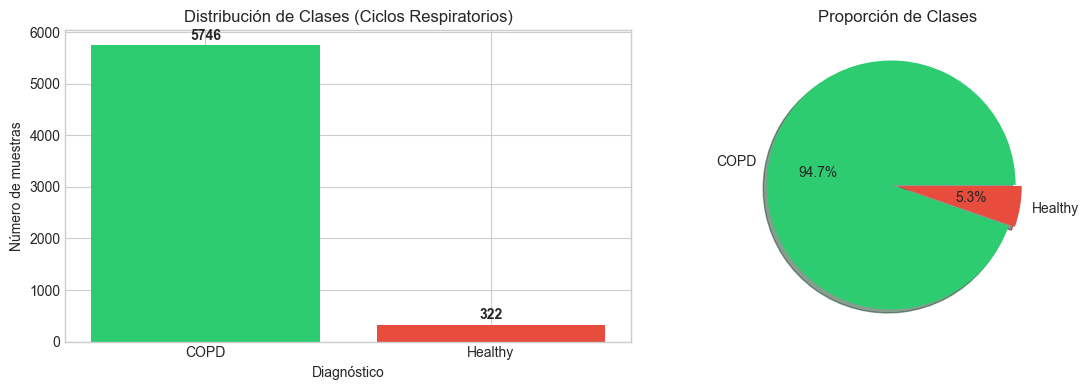

In [4]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================
print("=" * 60)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 60)

# Class distribution
class_counts = features_df['diagnosis'].value_counts()
print(f"\n📈 Distribución de clases:")
for cls, count in class_counts.items():
    pct = count / len(features_df) * 100
    print(f"   {cls}: {count} muestras ({pct:.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n⚠️ Ratio de desbalanceo: {imbalance_ratio:.1f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(class_counts.index, class_counts.values, color=colors)
ax1.set_xlabel('Diagnóstico')
ax1.set_ylabel('Número de muestras')
ax1.set_title('Distribución de Clases (Ciclos Respiratorios)')
for bar, val in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{val}', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=colors, explode=[0.05, 0], shadow=True)
ax2.set_title('Proporción de Clases')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


In [5]:
# =============================================================================
# PATIENT DISTRIBUTION ANALYSIS
# =============================================================================
print("=" * 60)
print("DISTRIBUCIÓN POR PACIENTE")
print("=" * 60)

# Samples per patient
samples_per_patient = features_df.groupby('patient_id').size()
diagnosis_per_patient = features_df.groupby('patient_id')['diagnosis'].first()

print(f"\n👥 Estadísticas por paciente:")
print(f"   Pacientes Healthy: {(diagnosis_per_patient == 'Healthy').sum()}")
print(f"   Pacientes COPD: {(diagnosis_per_patient == 'COPD').sum()}")
print(f"\n   Muestras por paciente:")
print(f"   - Mínimo: {samples_per_patient.min()}")
print(f"   - Máximo: {samples_per_patient.max()}")
print(f"   - Media: {samples_per_patient.mean():.1f}")
print(f"   - Mediana: {samples_per_patient.median():.1f}")

print("\n⚠️ IMPORTANTE: Las muestras NO son i.i.d.")
print("   Múltiples ciclos respiratorios provienen del mismo paciente.")
print("   El split debe hacerse POR PACIENTE para evitar data leakage.")


DISTRIBUCIÓN POR PACIENTE

👥 Estadísticas por paciente:
   Pacientes Healthy: 26
   Pacientes COPD: 64

   Muestras por paciente:
   - Mínimo: 4
   - Máximo: 507
   - Media: 67.4
   - Mediana: 45.5

⚠️ IMPORTANTE: Las muestras NO son i.i.d.
   Múltiples ciclos respiratorios provienen del mismo paciente.
   El split debe hacerse POR PACIENTE para evitar data leakage.


## 3. Diseño Experimental

### 3.1 Estrategia de partición

Se utiliza **split por paciente** (GroupShuffleSplit) para garantizar que todos los ciclos respiratorios de un mismo paciente permanezcan en el mismo conjunto (train o test). Esto evita el data leakage que ocurriría si ciclos del mismo paciente aparecieran en ambos conjuntos, ya que son altamente correlacionados.

- **Train:** 80% de los pacientes
- **Test:** 20% de los pacientes

### 3.2 Gestión del desbalanceo

El dataset presenta un desbalanceo severo (~18:1). Para manejarlo:

1. **Pesos de clase:** Todos los modelos utilizan `class_weight='balanced'` o su equivalente, ponderando la pérdida inversamente proporcional a la frecuencia de clase.

2. **Métricas robustas:** Se priorizan métricas insensibles al desbalanceo (balanced accuracy, F1, PR-AUC) sobre accuracy simple.

3. **Subsampling para cuántico:** Para los modelos cuánticos, se aplica undersampling balanceado para hacer viable la simulación, manteniendo proporción 1:1.

### 3.3 Métricas oficiales

| Métrica | Descripción | Prioridad |
|---------|-------------|----------|
| Balanced Accuracy | Media de recall por clase | Alta |
| F1 (minoritaria) | F1-Score para clase Healthy | Alta |
| PR-AUC | Área bajo curva Precision-Recall | Alta |
| Recall (minoritaria) | Sensibilidad para Healthy | Media |
| ROC-AUC | Área bajo curva ROC | Media |
| Accuracy | Precisión global | Baja (sesgada) |

### 3.4 Control de aleatoriedad

Todas las semillas están fijadas: `numpy.random.seed(42)`, `torch.manual_seed(42)`, `random.seed(42)`.


In [6]:
# =============================================================================
# PATIENT-WISE TRAIN/TEST SPLIT
# =============================================================================
print("=" * 60)
print("PARTICIÓN POR PACIENTE (TRAIN/TEST)")
print("=" * 60)

# Get feature columns
extractor = AudioFeatureExtractor()
feature_cols = extractor.feature_names

# Patient-wise split
splitter = PatientWiseSplitter(test_size=0.2, random_state=SEED)
train_df, test_df = splitter.split_dataframe(features_df)

print(f"\n📊 Resultado de la partición:")
print(f"   Entrenamiento: {len(train_df)} muestras ({len(train_df)/len(features_df)*100:.1f}%)")
print(f"   Test: {len(test_df)} muestras ({len(test_df)/len(features_df)*100:.1f}%)")
print(f"\n   Pacientes en train: {train_df['patient_id'].nunique()}")
print(f"   Pacientes en test: {test_df['patient_id'].nunique()}")

# Verify no overlap
train_patients = set(train_df['patient_id'])
test_patients = set(test_df['patient_id'])
overlap = train_patients & test_patients
print(f"\n✅ Verificación: Pacientes en común = {len(overlap)} (debe ser 0)")

# Class distribution in each split
print(f"\n📈 Distribución de clases en train:")
for cls in ['Healthy', 'COPD']:
    count = (train_df['diagnosis'] == cls).sum()
    pct = count / len(train_df) * 100
    print(f"   {cls}: {count} ({pct:.1f}%)")

print(f"\n📈 Distribución de clases en test:")
for cls in ['Healthy', 'COPD']:
    count = (test_df['diagnosis'] == cls).sum()
    pct = count / len(test_df) * 100
    print(f"   {cls}: {count} ({pct:.1f}%)")


PARTICIÓN POR PACIENTE (TRAIN/TEST)

📊 Resultado de la partición:
   Entrenamiento: 5148 muestras (84.8%)
   Test: 920 muestras (15.2%)

   Pacientes en train: 72
   Pacientes en test: 18

✅ Verificación: Pacientes en común = 0 (debe ser 0)

📈 Distribución de clases en train:
   Healthy: 261 (5.1%)
   COPD: 4887 (94.9%)

📈 Distribución de clases en test:
   Healthy: 61 (6.6%)
   COPD: 859 (93.4%)


## 4. Preprocesado y Reducción (Sin Leakage)

### 4.1 Pipeline de preprocesado

El orden correcto del pipeline es crítico para evitar data leakage:

1. **Split train/test** (ya realizado por paciente)
2. **Fit de escalado y PCA** solo con datos de entrenamiento
3. **Transform** aplicado a train y test por separado
4. **Normalización cuántica** (escalar a [-π, π]) solo después del split

**Regla fundamental:** Ningún `fit_transform` sobre todo el dataset antes del split.

### 4.2 Justificación de la reducción dimensional

- Las features originales son 52 (13 MFCCs × 4 estadísticas).
- Los simuladores cuánticos escalan exponencialmente: simular 52 qubits es imposible.
- PCA reduce a 8 componentes (= 8 qubits), conservando ~67% de la varianza.
- El kernel cuántico tiene complejidad O(N²) en el número de muestras, limitando el tamaño viable.


In [7]:
# =============================================================================
# FEATURE EXTRACTION AND DIMENSIONALITY REDUCTION (NO LEAKAGE)
# =============================================================================
print("=" * 60)
print("PREPROCESADO Y REDUCCIÓN DIMENSIONAL")
print("=" * 60)

# Extract features and labels
X_train_raw = train_df[feature_cols].values
y_train = train_df['label'].values
X_test_raw = test_df[feature_cols].values
y_test = test_df['label'].values

print(f"\n📊 Shapes originales:")
print(f"   X_train: {X_train_raw.shape}")
print(f"   X_test: {X_test_raw.shape}")

# =============================================================================
# STEP 1: FIT PCA ONLY ON TRAINING DATA (CRITICAL: NO LEAKAGE)
# =============================================================================
print(f"\n🔧 Reducción dimensional (PCA):")
print(f"   Componentes objetivo: {N_COMPONENTS_PCA} (= número de qubits)")

reducer = DimensionalityReducer(n_components=N_COMPONENTS_PCA)

# FIT ONLY ON TRAIN
reducer.fit(X_train_raw)

# TRANSFORM BOTH
X_train_pca = reducer.transform(X_train_raw)
X_test_pca = reducer.transform(X_test_raw)

print(f"\n📊 Shapes tras PCA:")
print(f"   X_train_pca: {X_train_pca.shape}")
print(f"   X_test_pca: {X_test_pca.shape}")

# Print variance explained
print(f"\n📈 Varianza explicada:")
cumvar = 0
for i, var in enumerate(reducer.explained_variance_ratio):
    cumvar += var
    print(f"   PC{i+1}: {var:.4f} (acumulada: {cumvar:.4f})")
print(f"\n   Total varianza retenida: {reducer.total_explained_variance:.2%}")


PREPROCESADO Y REDUCCIÓN DIMENSIONAL

📊 Shapes originales:
   X_train: (5148, 52)
   X_test: (920, 52)

🔧 Reducción dimensional (PCA):
   Componentes objetivo: 8 (= número de qubits)

📊 Shapes tras PCA:
   X_train_pca: (5148, 8)
   X_test_pca: (920, 8)

📈 Varianza explicada:
   PC1: 0.3032 (acumulada: 0.3032)
   PC2: 0.0907 (acumulada: 0.3939)
   PC3: 0.0762 (acumulada: 0.4701)
   PC4: 0.0512 (acumulada: 0.5213)
   PC5: 0.0457 (acumulada: 0.5670)
   PC6: 0.0417 (acumulada: 0.6088)
   PC7: 0.0362 (acumulada: 0.6450)
   PC8: 0.0298 (acumulada: 0.6748)

   Total varianza retenida: 67.48%


In [8]:
# =============================================================================
# STEP 2: QUANTUM NORMALIZATION (AFTER SPLIT)
# =============================================================================
print("=" * 60)
print("NORMALIZACIÓN PARA CODIFICACIÓN CUÁNTICA")
print("=" * 60)

# Normalize to [-pi, pi] for angle embedding
# IMPORTANT: Fit normalization params on train, apply to test
X_train_min = X_train_pca.min(axis=0)
X_train_max = X_train_pca.max(axis=0)
X_train_range = X_train_max - X_train_min
X_train_range[X_train_range == 0] = 1  # Avoid division by zero

# Apply same normalization to both train and test
X_train_quantum = (X_train_pca - X_train_min) / X_train_range * 2 * np.pi - np.pi
X_test_quantum = (X_test_pca - X_train_min) / X_train_range * 2 * np.pi - np.pi

# Clip test to valid range (some values may exceed if test has different range)
X_test_quantum = np.clip(X_test_quantum, -np.pi, np.pi)

print(f"\n📊 Rango de valores normalizados:")
print(f"   Train: [{X_train_quantum.min():.4f}, {X_train_quantum.max():.4f}]")
print(f"   Test:  [{X_test_quantum.min():.4f}, {X_test_quantum.max():.4f}]")
print(f"\n✅ Datos listos para codificación cuántica (angle embedding)")


NORMALIZACIÓN PARA CODIFICACIÓN CUÁNTICA

📊 Rango de valores normalizados:
   Train: [-3.1416, 3.1416]
   Test:  [-3.1416, 3.1416]

✅ Datos listos para codificación cuántica (angle embedding)


In [9]:
# =============================================================================
# COMPUTE CLASS WEIGHTS FOR IMBALANCED DATA
# =============================================================================
print("=" * 60)
print("CÁLCULO DE PESOS DE CLASE")
print("=" * 60)

# Compute balanced class weights
classes = np.unique(y_train)
class_weights_array = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights_array))

print(f"\n📊 Distribución de clases en train:")
n_healthy = (y_train == 0).sum()
n_copd = (y_train == 1).sum()
print(f"   Healthy (0): {n_healthy} ({n_healthy/len(y_train)*100:.1f}%)")
print(f"   COPD (1): {n_copd} ({n_copd/len(y_train)*100:.1f}%)")

print(f"\n⚖️ Pesos de clase calculados:")
print(f"   Healthy (0): {class_weight_dict[0]:.4f}")
print(f"   COPD (1): {class_weight_dict[1]:.4f}")

# pos_weight for BCEWithLogitsLoss (n_neg / n_pos = weight for positive class)
# In our case: COPD is positive (1), so pos_weight = n_healthy / n_copd
pos_weight_hybrid = n_healthy / n_copd
print(f"\n   pos_weight (para híbrido): {pos_weight_hybrid:.4f}")
print(f"   → La clase minoritaria (Healthy) tiene {class_weight_dict[0]/class_weight_dict[1]:.1f}x más peso")


CÁLCULO DE PESOS DE CLASE

📊 Distribución de clases en train:
   Healthy (0): 261 (5.1%)
   COPD (1): 4887 (94.9%)

⚖️ Pesos de clase calculados:
   Healthy (0): 9.8621
   COPD (1): 0.5267

   pos_weight (para híbrido): 0.0534
   → La clase minoritaria (Healthy) tiene 18.7x más peso


In [10]:
# =============================================================================
# PREPARE SUBSETS FOR QUANTUM MODELS
# =============================================================================
print("=" * 60)
print("PREPARACIÓN DE SUBCONJUNTOS PARA MODELOS CUÁNTICOS")
print("=" * 60)

print("\n⚠️ Limitaciones de simulación cuántica:")
print("   - El kernel cuántico tiene complejidad O(N²)")
print("   - Con 5000+ muestras, el tiempo sería prohibitivo")
print("   - Usamos subconjuntos balanceados para hacer viable la comparación")

def create_balanced_subset(X, y, n_per_class, seed=42):
    """Create a balanced subset with n_per_class samples per class."""
    np.random.seed(seed)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    
    # Sample from each class
    n_0 = min(n_per_class, len(idx_0))
    n_1 = min(n_per_class, len(idx_1))
    
    sampled_0 = np.random.choice(idx_0, n_0, replace=False)
    sampled_1 = np.random.choice(idx_1, n_1, replace=False)
    
    all_idx = np.concatenate([sampled_0, sampled_1])
    np.random.shuffle(all_idx)
    
    return X[all_idx], y[all_idx]

# Create balanced subsets for quantum models
N_TRAIN_QUANTUM = 75  # 75 per class = 150 total
N_TEST_QUANTUM = 30   # 30 per class = 60 total

X_train_q, y_train_q = create_balanced_subset(X_train_quantum, y_train, N_TRAIN_QUANTUM, seed=SEED)
X_test_q, y_test_q = create_balanced_subset(X_test_quantum, y_test, N_TEST_QUANTUM, seed=SEED)

print(f"\n📊 Subconjuntos balanceados para cuántico:")
print(f"   Train: {len(X_train_q)} muestras (Healthy: {(y_train_q==0).sum()}, COPD: {(y_train_q==1).sum()})")
print(f"   Test:  {len(X_test_q)} muestras (Healthy: {(y_test_q==0).sum()}, COPD: {(y_test_q==1).sum()})")


PREPARACIÓN DE SUBCONJUNTOS PARA MODELOS CUÁNTICOS

⚠️ Limitaciones de simulación cuántica:
   - El kernel cuántico tiene complejidad O(N²)
   - Con 5000+ muestras, el tiempo sería prohibitivo
   - Usamos subconjuntos balanceados para hacer viable la comparación

📊 Subconjuntos balanceados para cuántico:
   Train: 150 muestras (Healthy: 75, COPD: 75)
   Test:  60 muestras (Healthy: 30, COPD: 30)


## 5. Modelos

A continuación se entrenan y evalúan los cuatro modelos bajo el mismo protocolo experimental. Todos utilizan tratamiento explícito del desbalanceo de clases.


### 5.1 Baseline Clásico: SVM con Kernel RBF

El SVM clásico con kernel RBF (Radial Basis Function) es un clasificador robusto y bien establecido. Se utiliza como baseline para comparar con los modelos cuánticos.

**Configuración:**
- Kernel: RBF (Gaussian)
- C: 1.0 (regularización por defecto)
- Gamma: 'scale' (1 / (n_features × var(X)))
- `class_weight='balanced'`: Pondera automáticamente las clases inversamente proporcional a su frecuencia

**Tratamiento del desbalanceo:** El parámetro `class_weight='balanced'` ajusta los pesos de las muestras para que la clase minoritaria tenga mayor influencia en la optimización.


In [11]:
# =============================================================================
# MODEL 1: CLASSICAL SVM (BASELINE)
# =============================================================================
print("=" * 60)
print("MODELO 1: SVM CLÁSICO (BASELINE)")
print("=" * 60)

# Train on FULL PCA data (no subsampling needed for classical)
print("\n🔧 Configuración:")
print("   - Kernel: RBF")
print("   - C: 1.0")
print("   - class_weight: 'balanced'")

classical_svm = ClassicalSVM(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=SEED
)

# Train
t_start = time.time()
classical_svm.fit(X_train_pca, y_train)
train_time_classical = time.time() - t_start

# Predict on FULL test set
t_start = time.time()
y_pred_classical = classical_svm.predict(X_test_pca)
y_prob_classical = classical_svm.predict_proba(X_test_pca)[:, 1]
test_time_classical = time.time() - t_start

print(f"\n⏱️ Tiempos:")
print(f"   Entrenamiento: {train_time_classical:.2f}s")
print(f"   Inferencia: {test_time_classical:.4f}s")


MODELO 1: SVM CLÁSICO (BASELINE)

🔧 Configuración:
   - Kernel: RBF
   - C: 1.0
   - class_weight: 'balanced'
Classical SVM trained in 1.67 seconds

⏱️ Tiempos:
   Entrenamiento: 1.67s
   Inferencia: 0.2480s


### 5.2 QSVM: Quantum Kernel SVM

El QSVM utiliza un kernel cuántico para medir la similitud entre muestras en un espacio de Hilbert de alta dimensionalidad. El kernel se calcula mediante un circuito cuántico:

$$K(x_i, x_j) = |\langle\phi(x_i)|\phi(x_j)\rangle|^2$$

Donde $|\phi(x)\rangle$ es el estado cuántico tras aplicar el feature map.

**Configuración:**
- Qubits: 8 (= dimensiones tras PCA)
- Feature map: Custom (Hadamard + RZ + CNOT + RY)
- `class_weight='balanced'`: Aplicado al SVC con kernel precomputado

**Limitaciones:** El kernel cuántico tiene complejidad O(N²), por lo que se entrena sobre un subconjunto balanceado.


In [12]:
# =============================================================================
# MODEL 2: QUANTUM KERNEL SVM (QSVM)
# =============================================================================
print("=" * 60)
print("MODELO 2: QSVM (KERNEL CUÁNTICO)")
print("=" * 60)

print("\n🔧 Configuración:")
print(f"   - Qubits: {N_QUBITS}")
print("   - Feature map: custom (H + RZ + CNOT + RY)")
print("   - class_weight: 'balanced'")
print(f"   - Muestras train: {len(X_train_q)} (balanceado)")

qsvm = QuantumKernelSVM(
    n_qubits=N_QUBITS,
    feature_map="custom",
    C=1.0,
    class_weight='balanced',
    random_state=SEED
)

# Train on balanced subset
t_start = time.time()
qsvm.fit(X_train_q, y_train_q, show_progress=True)
train_time_qsvm = time.time() - t_start

# Predict on balanced test subset
t_start = time.time()
y_pred_qsvm = qsvm.predict(X_test_q, show_progress=True)
y_prob_qsvm = qsvm.predict_proba(X_test_q, show_progress=False)[:, 1]
test_time_qsvm = time.time() - t_start

print(f"\n⏱️ Tiempos:")
print(f"   Entrenamiento: {train_time_qsvm:.2f}s")
print(f"   Inferencia: {test_time_qsvm:.2f}s")


MODELO 2: QSVM (KERNEL CUÁNTICO)

🔧 Configuración:
   - Qubits: 8
   - Feature map: custom (H + RZ + CNOT + RY)
   - class_weight: 'balanced'
   - Muestras train: 150 (balanceado)
Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Using Lightning CPU device
QSVM using device: <lightning.qubit device (wires=8) at 0x250d7514ac0>
Computing quantum kernel matrix (150x150)...


Computing kernel (symmetric): 100%|██████████| 11325/11325 [01:21<00:00, 138.87it/s]


QSVM trained in 81.56 seconds


Computing kernel: 100%|██████████| 9000/9000 [01:08<00:00, 130.45it/s]



⏱️ Tiempos:
   Entrenamiento: 81.56s
   Inferencia: 136.50s


### 5.3 VQC: Variational Quantum Classifier

El VQC utiliza un circuito cuántico parametrizado que se optimiza durante el entrenamiento:

1. **Codificación:** Los datos clásicos se codifican como ángulos de rotación (Angle Embedding).
2. **Circuito variacional:** Capas de puertas entrelazantes con parámetros entrenables (StronglyEntanglingLayers).
3. **Medición:** Se mide el valor esperado de Pauli-Z en el primer qubit.

**Configuración:**
- Qubits: 8
- Capas variacionales: 3
- Optimizador: Adam (lr=0.1)
- Épocas: 50
- `class_weight`: Ponderación aplicada a la función de coste MSE


In [13]:
# =============================================================================
# MODEL 3: VARIATIONAL QUANTUM CLASSIFIER (VQC)
# =============================================================================
print("=" * 60)
print("MODELO 3: VQC (CLASIFICADOR VARIACIONAL CUÁNTICO)")
print("=" * 60)

print("\n🔧 Configuración:")
print(f"   - Qubits: {N_QUBITS}")
print(f"   - Capas variacionales: {N_LAYERS_VQC}")
print("   - Optimizador: Adam (lr=0.1)")
print("   - Épocas: 50")
print("   - class_weight: 'balanced' (en función de coste)")

vqc = VariationalQuantumClassifier(
    n_qubits=N_QUBITS,
    n_layers=N_LAYERS_VQC,
    learning_rate=0.1,
    epochs=50,
    class_weight=class_weight_dict,
    random_state=SEED
)

# Train on balanced subset
t_start = time.time()
vqc.fit(X_train_q, y_train_q, verbose=True)
train_time_vqc = time.time() - t_start

# Predict on balanced test subset
t_start = time.time()
y_pred_vqc = vqc.predict(X_test_q)
y_prob_vqc = vqc.predict_proba(X_test_q)[:, 1]
test_time_vqc = time.time() - t_start

print(f"\n⏱️ Tiempos:")
print(f"   Entrenamiento: {train_time_vqc:.2f}s")
print(f"   Inferencia: {test_time_vqc:.4f}s")


MODELO 3: VQC (CLASIFICADOR VARIACIONAL CUÁNTICO)

🔧 Configuración:
   - Qubits: 8
   - Capas variacionales: 3
   - Optimizador: Adam (lr=0.1)
   - Épocas: 50
   - class_weight: 'balanced' (en función de coste)
Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Using Lightning CPU device
VQC using device: <lightning.qubit device (wires=8) at 0x2508e12cf70>


Training VQC:   0%|          | 0/50 [00:00<?, ?it/s]

Training VQC: 100%|██████████| 50/50 [03:03<00:00,  3.67s/it, loss=0.1930]


VQC trained in 183.75 seconds
Final loss: 0.1930

⏱️ Tiempos:
   Entrenamiento: 183.75s
   Inferencia: 1.0200s


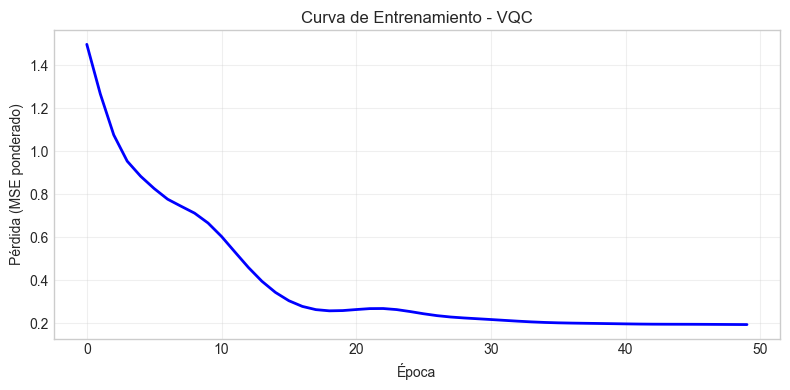

In [14]:
# Plot VQC training history
if hasattr(vqc, 'training_history') and vqc.training_history:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(vqc.training_history, 'b-', linewidth=2)
    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida (MSE ponderado)')
    ax.set_title('Curva de Entrenamiento - VQC')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'vqc_training.png', dpi=150, bbox_inches='tight')
    plt.show()


### 5.4 Modelo Híbrido Cuántico-Clásico

El modelo híbrido combina capas clásicas de redes neuronales con una capa cuántica:

```
Input(8) → Dense(32) → ReLU → Dropout(0.2) → Dense(16) → ReLU → Dense(4)
         → QuantumLayer(4 qubits, 2 capas) 
         → Dense(8) → ReLU → Dense(1) → Logits
```

**Configuración:**
- Qubits cuánticos: 4
- Capas variacionales: 2
- Optimizador: Adam (lr=0.01)
- Épocas: 30
- Pérdida: `BCEWithLogitsLoss(pos_weight=n_neg/n_pos)` para manejar desbalanceo

**Tratamiento del desbalanceo:** Se utiliza `BCEWithLogitsLoss` con `pos_weight` que pondera la clase positiva. Además, la salida es logits (sin sigmoid), lo que es numéricamente más estable.


In [15]:
# =============================================================================
# MODEL 4: HYBRID QUANTUM-CLASSICAL NETWORK
# =============================================================================
print("=" * 60)
print("MODELO 4: HÍBRIDO CUÁNTICO-CLÁSICO")
print("=" * 60)

# Calculate pos_weight for imbalanced data (for the balanced subset)
n_neg_q = (y_train_q == 0).sum()
n_pos_q = (y_train_q == 1).sum()
pos_weight_q = n_neg_q / n_pos_q  # Should be ~1.0 for balanced subset

print("\n🔧 Configuración:")
print(f"   - Input dim: {N_QUBITS}")
print(f"   - Qubits cuánticos: {N_QUBITS_HYBRID}")
print(f"   - Capas variacionales: {N_LAYERS_HYBRID}")
print("   - Optimizador: Adam (lr=0.01)")
print("   - Épocas: 30")
print(f"   - pos_weight: {pos_weight_q:.4f}")
print("   - Pérdida: BCEWithLogitsLoss (numéricamente estable)")

hybrid = HybridQuantumClassifier(
    input_dim=N_QUBITS,
    n_qubits=N_QUBITS_HYBRID,
    n_layers=N_LAYERS_HYBRID,
    learning_rate=0.01,
    epochs=30,
    batch_size=32,
    pos_weight=pos_weight_q,
    random_state=SEED
)

# Train on balanced subset
t_start = time.time()
hybrid.fit(X_train_q, y_train_q, verbose=True)
train_time_hybrid = time.time() - t_start

# Predict on balanced test subset
t_start = time.time()
y_pred_hybrid = hybrid.predict(X_test_q)
y_prob_hybrid = hybrid.predict_proba(X_test_q)[:, 1]
test_time_hybrid = time.time() - t_start

print(f"\n⏱️ Tiempos:")
print(f"   Entrenamiento: {train_time_hybrid:.2f}s")
print(f"   Inferencia: {test_time_hybrid:.4f}s")


MODELO 4: HÍBRIDO CUÁNTICO-CLÁSICO

🔧 Configuración:
   - Input dim: 8
   - Qubits cuánticos: 4
   - Capas variacionales: 2
   - Optimizador: Adam (lr=0.01)
   - Épocas: 30
   - pos_weight: 1.0000
   - Pérdida: BCEWithLogitsLoss (numéricamente estable)
🖥️ PyTorch using: cuda
   GPU: NVIDIA GeForce RTX 3060
   CUDA Version: 12.1
   Using Lightning CPU for quantum layer
⚛️ Quantum device: <lightning.qubit device (wires=4) at 0x2508e0d2e90>


Training Hybrid (cuda): 100%|██████████| 30/30 [03:47<00:00,  7.60s/it, loss: 0.2201]


Hybrid model trained in 227.99 seconds
Final loss: 0.2201

⏱️ Tiempos:
   Entrenamiento: 227.99s
   Inferencia: 1.1390s


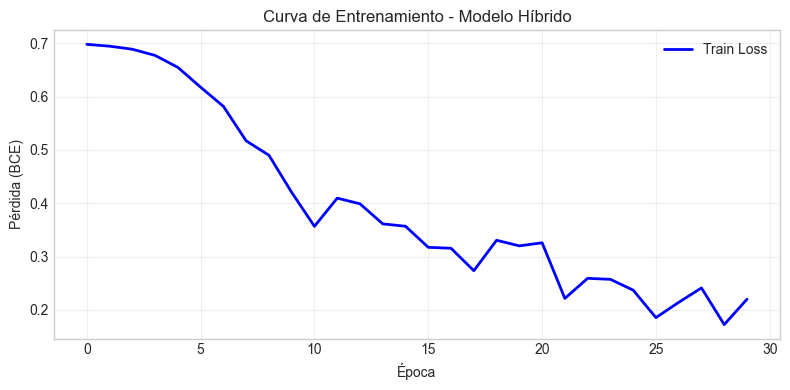

In [16]:
# Plot Hybrid training history
if hasattr(hybrid, 'training_history') and 'loss' in hybrid.training_history:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(hybrid.training_history['loss'], 'b-', linewidth=2, label='Train Loss')
    if hybrid.training_history.get('val_loss'):
        ax.plot(hybrid.training_history['val_loss'], 'r--', linewidth=2, label='Val Loss')
    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida (BCE)')
    ax.set_title('Curva de Entrenamiento - Modelo Híbrido')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'hybrid_training.png', dpi=150, bbox_inches='tight')
    plt.show()


## 6. Protocolo de Evaluación Común

### 6.1 Consideraciones importantes

**Comparación justa:**
- El SVM clásico se evalúa sobre el **test completo** (920 muestras) porque puede procesarlo eficientemente.
- Los modelos cuánticos se evalúan sobre el **subconjunto balanceado** (60 muestras) debido a limitaciones de simulación.

Esta diferencia es importante al interpretar resultados: el test completo preserva el desbalanceo real del problema, mientras que el subconjunto balanceado facilita la comparación pero no refleja el escenario de producción.

Para una comparación más equitativa, también evaluaremos el SVM clásico sobre el mismo subconjunto balanceado.


In [17]:
# =============================================================================
# EVALUATE CLASSICAL SVM ON BALANCED SUBSET (FOR FAIR COMPARISON)
# =============================================================================
print("=" * 60)
print("EVALUACIÓN COMPARATIVA EN SUBCONJUNTO BALANCEADO")
print("=" * 60)

# Get indices of the balanced subset for fair comparison
np.random.seed(SEED)
idx_0_test = np.where(y_test == 0)[0]
idx_1_test = np.where(y_test == 1)[0]
n_0 = min(N_TEST_QUANTUM, len(idx_0_test))
n_1 = min(N_TEST_QUANTUM, len(idx_1_test))
sampled_0 = np.random.choice(idx_0_test, n_0, replace=False)
sampled_1 = np.random.choice(idx_1_test, n_1, replace=False)
balanced_idx = np.concatenate([sampled_0, sampled_1])
np.random.shuffle(balanced_idx)

# Get PCA features for balanced subset
X_test_pca_balanced = X_test_pca[balanced_idx]
y_test_balanced = y_test[balanced_idx]

# Evaluate classical SVM on balanced subset
y_pred_classical_balanced = classical_svm.predict(X_test_pca_balanced)
y_prob_classical_balanced = classical_svm.predict_proba(X_test_pca_balanced)[:, 1]

print(f"\n📊 Test balanceado: {len(y_test_balanced)} muestras")
print(f"   Healthy: {(y_test_balanced==0).sum()}, COPD: {(y_test_balanced==1).sum()}")
print("\n✅ Todos los modelos evaluados sobre el mismo conjunto de test balanceado")


EVALUACIÓN COMPARATIVA EN SUBCONJUNTO BALANCEADO

📊 Test balanceado: 60 muestras
   Healthy: 30, COPD: 30

✅ Todos los modelos evaluados sobre el mismo conjunto de test balanceado


In [18]:
# =============================================================================
# COMPUTE ALL METRICS
# =============================================================================
print("=" * 60)
print("CÁLCULO DE MÉTRICAS")
print("=" * 60)

def compute_all_metrics(y_true, y_pred, y_prob, model_name):
    """Compute all relevant metrics for a model."""
    metrics = {
        'Model': model_name,
        'Balanced Acc': balanced_accuracy_score(y_true, y_pred),
        'F1 (Healthy)': f1_score(y_true, y_pred, pos_label=0),
        'Recall (Healthy)': recall_score(y_true, y_pred, pos_label=0),
        'F1 (Macro)': f1_score(y_true, y_pred, average='macro'),
    }
    
    # PR-AUC and ROC-AUC require probabilities
    if y_prob is not None and len(np.unique(y_true)) > 1:
        try:
            # For PR-AUC of minority class (Healthy=0), we need to invert probabilities
            metrics['PR-AUC (Healthy)'] = average_precision_score(1 - y_true, 1 - y_prob)
            metrics['ROC-AUC'] = roc_auc_score(y_true, y_prob)
        except Exception:
            metrics['PR-AUC (Healthy)'] = np.nan
            metrics['ROC-AUC'] = np.nan
    else:
        metrics['PR-AUC (Healthy)'] = np.nan
        metrics['ROC-AUC'] = np.nan
    
    return metrics

# Compute metrics for all models on balanced test set
results_balanced = []

# Classical SVM (on balanced subset)
results_balanced.append(compute_all_metrics(
    y_test_balanced, y_pred_classical_balanced, y_prob_classical_balanced, 'SVM Clásico'
))

# QSVM
results_balanced.append(compute_all_metrics(
    y_test_q, y_pred_qsvm, y_prob_qsvm, 'QSVM'
))

# VQC
results_balanced.append(compute_all_metrics(
    y_test_q, y_pred_vqc, y_prob_vqc, 'VQC'
))

# Hybrid
results_balanced.append(compute_all_metrics(
    y_test_q, y_pred_hybrid, y_prob_hybrid, 'Híbrido'
))

# Create DataFrame
df_results_balanced = pd.DataFrame(results_balanced)
df_results_balanced = df_results_balanced.set_index('Model')

print("\n📊 Resultados sobre test balanceado (comparación justa):")
print(df_results_balanced.round(4).to_string())


CÁLCULO DE MÉTRICAS

📊 Resultados sobre test balanceado (comparación justa):
             Balanced Acc  F1 (Healthy)  Recall (Healthy)  F1 (Macro)  PR-AUC (Healthy)  ROC-AUC
Model                                                                                           
SVM Clásico        0.7667        0.7083            0.5667      0.7569            0.9175   0.9044
QSVM               0.8167        0.7843            0.6667      0.8124            0.9207   0.8900
VQC                0.5333        0.6744            0.9667      0.4254            0.6617   0.6944
Híbrido            0.7500        0.7059            0.6000      0.7442            0.7395   0.7922


In [19]:
# =============================================================================
# ADDITIONAL: CLASSICAL SVM ON FULL TEST (REALISTIC SCENARIO)
# =============================================================================
print("\n" + "=" * 60)
print("SVM CLÁSICO EN TEST COMPLETO (ESCENARIO REALISTA)")
print("=" * 60)

metrics_classical_full = compute_all_metrics(
    y_test, y_pred_classical, y_prob_classical, 'SVM Clásico (Full Test)'
)

print("\n📊 Resultados del SVM clásico en test completo (desbalanceado):")
for key, value in metrics_classical_full.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")



SVM CLÁSICO EN TEST COMPLETO (ESCENARIO REALISTA)

📊 Resultados del SVM clásico en test completo (desbalanceado):
   Balanced Acc: 0.7741
   F1 (Healthy): 0.5414
   Recall (Healthy): 0.5902
   F1 (Macro): 0.7528
   PR-AUC (Healthy): 0.5668
   ROC-AUC: 0.9316


## 7. Resultados

### 7.1 Tabla Comparativa Final


In [20]:
# =============================================================================
# FINAL COMPARISON TABLE WITH TIMES
# =============================================================================
print("=" * 70)
print("TABLA COMPARATIVA FINAL")
print("=" * 70)

# Add timing information
times_data = {
    'SVM Clásico': {'Train (s)': train_time_classical, 'Test (s)': test_time_classical},
    'QSVM': {'Train (s)': train_time_qsvm, 'Test (s)': test_time_qsvm},
    'VQC': {'Train (s)': train_time_vqc, 'Test (s)': test_time_vqc},
    'Híbrido': {'Train (s)': train_time_hybrid, 'Test (s)': test_time_hybrid},
}

# Add times to results
for model in df_results_balanced.index:
    df_results_balanced.loc[model, 'Train (s)'] = times_data[model]['Train (s)']
    df_results_balanced.loc[model, 'Test (s)'] = times_data[model]['Test (s)']

# Reorder columns
cols_order = ['Balanced Acc', 'F1 (Healthy)', 'Recall (Healthy)', 'F1 (Macro)', 
              'PR-AUC (Healthy)', 'ROC-AUC', 'Train (s)', 'Test (s)']
df_results_balanced = df_results_balanced[cols_order]

print("\n" + df_results_balanced.round(4).to_string())
print("\n" + "=" * 70)

# Highlight best model for each metric
print("\n🏆 Mejor modelo por métrica:")
for col in df_results_balanced.columns:
    if col not in ['Train (s)', 'Test (s)']:
        best_model = df_results_balanced[col].idxmax()
        best_val = df_results_balanced[col].max()
        print(f"   {col}: {best_model} ({best_val:.4f})")
    elif col == 'Train (s)':
        best_model = df_results_balanced[col].idxmin()
        best_val = df_results_balanced[col].min()
        print(f"   {col} (menor es mejor): {best_model} ({best_val:.2f}s)")


TABLA COMPARATIVA FINAL

             Balanced Acc  F1 (Healthy)  Recall (Healthy)  F1 (Macro)  PR-AUC (Healthy)  ROC-AUC  Train (s)  Test (s)
Model                                                                                                                
SVM Clásico        0.7667        0.7083            0.5667      0.7569            0.9175   0.9044     1.6740    0.2480
QSVM               0.8167        0.7843            0.6667      0.8124            0.9207   0.8900    81.5578  136.4953
VQC                0.5333        0.6744            0.9667      0.4254            0.6617   0.6944   183.7493    1.0200
Híbrido            0.7500        0.7059            0.6000      0.7442            0.7395   0.7922   227.9908    1.1390


🏆 Mejor modelo por métrica:
   Balanced Acc: QSVM (0.8167)
   F1 (Healthy): QSVM (0.7843)
   Recall (Healthy): VQC (0.9667)
   F1 (Macro): QSVM (0.8124)
   PR-AUC (Healthy): QSVM (0.9207)
   ROC-AUC: SVM Clásico (0.9044)
   Train (s) (menor es mejor): SVM Clásico (

MATRICES DE CONFUSIÓN


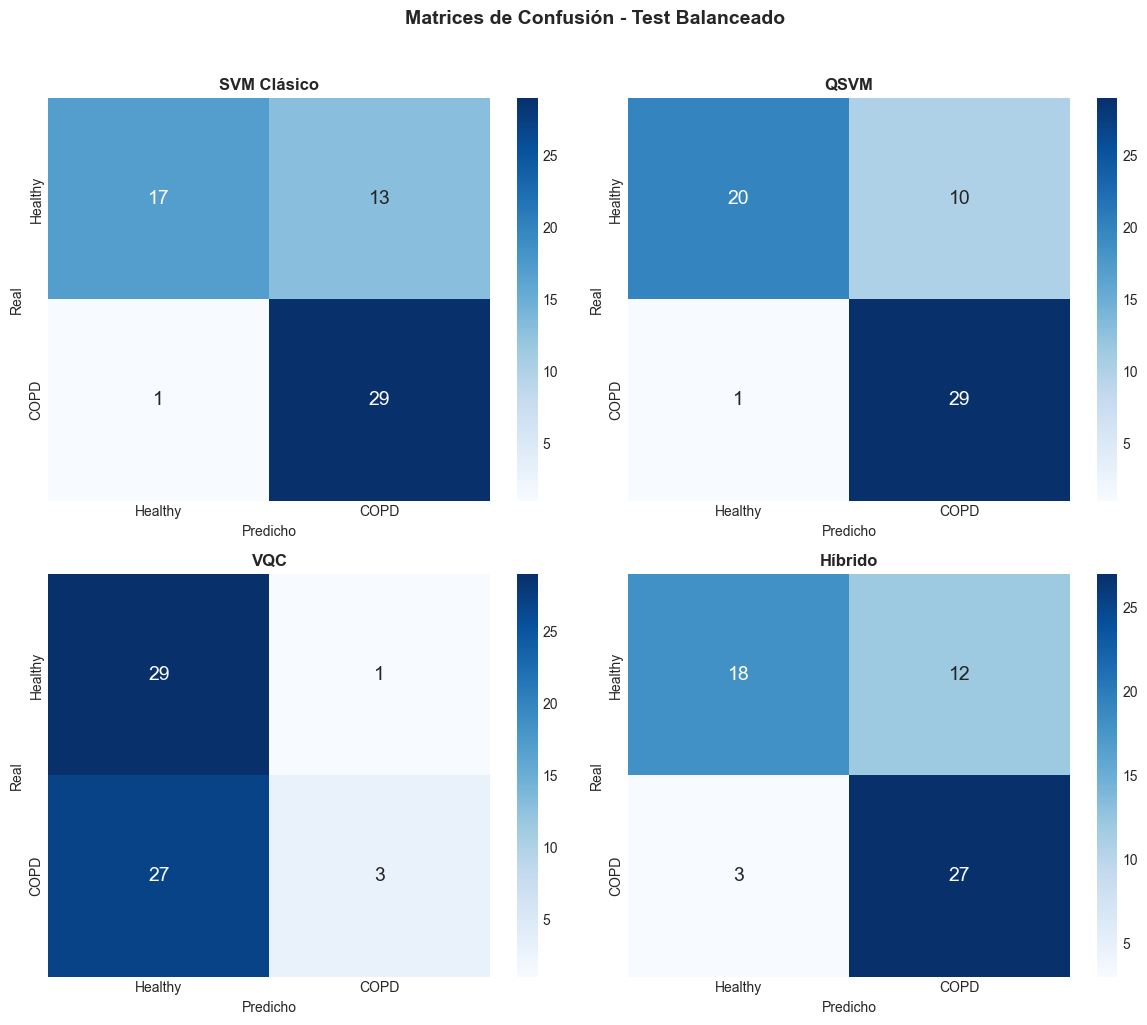

In [21]:
# =============================================================================
# CONFUSION MATRICES
# =============================================================================
print("=" * 60)
print("MATRICES DE CONFUSIÓN")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Compute confusion matrices
cms = [
    (confusion_matrix(y_test_balanced, y_pred_classical_balanced), 'SVM Clásico'),
    (confusion_matrix(y_test_q, y_pred_qsvm), 'QSVM'),
    (confusion_matrix(y_test_q, y_pred_vqc), 'VQC'),
    (confusion_matrix(y_test_q, y_pred_hybrid), 'Híbrido'),
]

for ax, (cm, title) in zip(axes.flat, cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Healthy', 'COPD'],
                yticklabels=['Healthy', 'COPD'],
                annot_kws={'size': 14})
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Real')
    ax.set_xlabel('Predicho')

plt.suptitle('Matrices de Confusión - Test Balanceado', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


CURVAS PRECISION-RECALL


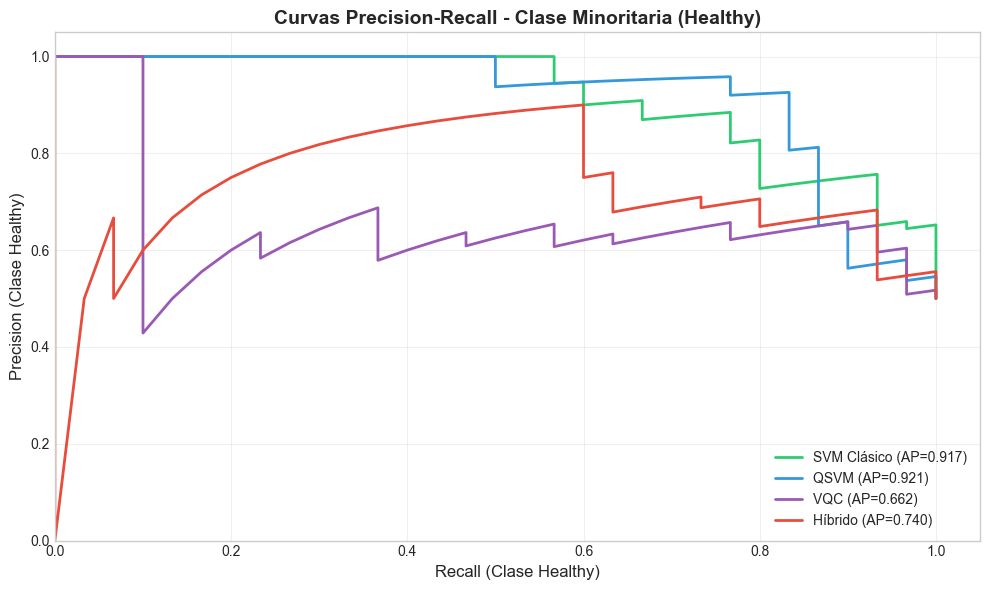

In [22]:
# =============================================================================
# PRECISION-RECALL CURVES (PRIORITY FOR IMBALANCED DATA)
# =============================================================================
print("=" * 60)
print("CURVAS PRECISION-RECALL")
print("=" * 60)

fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each model
colors = {'SVM Clásico': '#2ecc71', 'QSVM': '#3498db', 'VQC': '#9b59b6', 'Híbrido': '#e74c3c'}

# For minority class (Healthy=0), we invert labels and probabilities
pr_data = [
    (1 - y_test_balanced, 1 - y_prob_classical_balanced, 'SVM Clásico'),
    (1 - y_test_q, 1 - y_prob_qsvm, 'QSVM'),
    (1 - y_test_q, 1 - y_prob_vqc, 'VQC'),
    (1 - y_test_q, 1 - y_prob_hybrid, 'Híbrido'),
]

for y_true, y_score, name in pr_data:
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    ax.plot(recall, precision, color=colors[name], linewidth=2, 
            label=f'{name} (AP={ap:.3f})')

ax.set_xlabel('Recall (Clase Healthy)', fontsize=12)
ax.set_ylabel('Precision (Clase Healthy)', fontsize=12)
ax.set_title('Curvas Precision-Recall - Clase Minoritaria (Healthy)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()


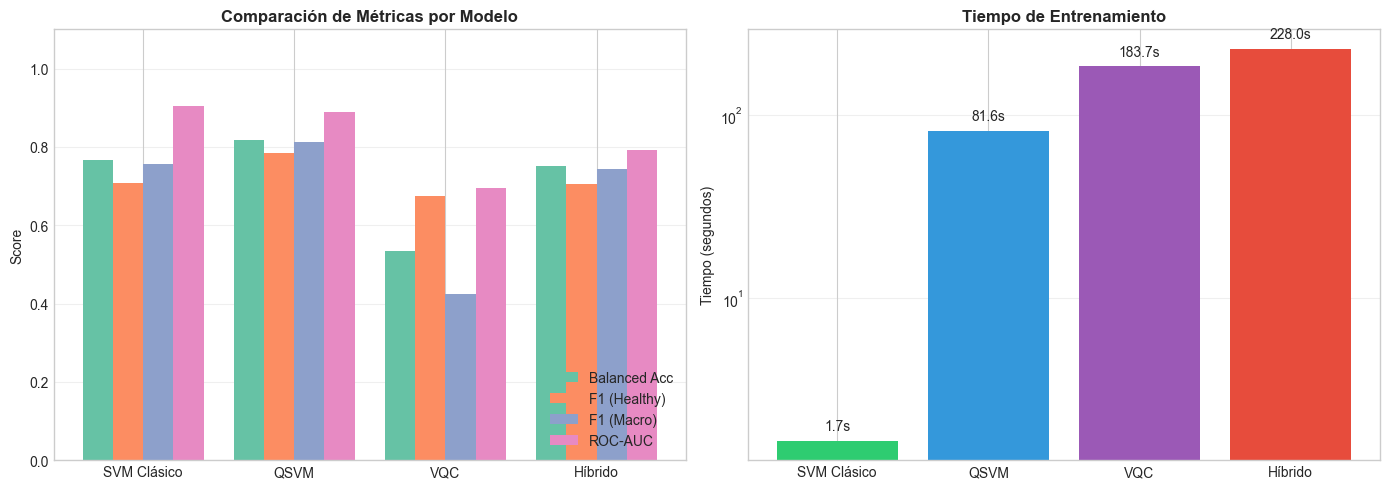

In [23]:
# =============================================================================
# BAR CHART COMPARISON
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
ax1 = axes[0]
metrics_to_plot = ['Balanced Acc', 'F1 (Healthy)', 'F1 (Macro)', 'ROC-AUC']
x = np.arange(len(df_results_balanced.index))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = df_results_balanced[metric].values
    ax1.bar(x + i*width, values, width, label=metric)

ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas por Modelo', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(df_results_balanced.index)
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', alpha=0.3)

# Training time comparison (log scale)
ax2 = axes[1]
train_times = df_results_balanced['Train (s)'].values
bars = ax2.bar(df_results_balanced.index, train_times, color=list(colors.values()))
ax2.set_ylabel('Tiempo (segundos)')
ax2.set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, val in zip(bars, train_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{val:.1f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Conclusiones

### 8.1 Resumen de Resultados


In [24]:
# =============================================================================
# SUMMARY AND CONCLUSIONS
# =============================================================================
print("=" * 70)
print("RESUMEN Y CONCLUSIONES")
print("=" * 70)

# Find best model for key metrics
best_balanced_acc = df_results_balanced['Balanced Acc'].idxmax()
best_f1_healthy = df_results_balanced['F1 (Healthy)'].idxmax()
best_pr_auc = df_results_balanced['PR-AUC (Healthy)'].idxmax()

print("\n📊 Rendimiento por métrica clave:")
print(f"\n   Balanced Accuracy (mejor): {best_balanced_acc}")
print(f"   → {df_results_balanced.loc[best_balanced_acc, 'Balanced Acc']:.2%}")

print(f"\n   F1 clase minoritaria (mejor): {best_f1_healthy}")
print(f"   → {df_results_balanced.loc[best_f1_healthy, 'F1 (Healthy)']:.2%}")

print(f"\n   PR-AUC clase minoritaria (mejor): {best_pr_auc}")
print(f"   → {df_results_balanced.loc[best_pr_auc, 'PR-AUC (Healthy)']:.4f}")


RESUMEN Y CONCLUSIONES

📊 Rendimiento por métrica clave:

   Balanced Accuracy (mejor): QSVM
   → 81.67%

   F1 clase minoritaria (mejor): QSVM
   → 78.43%

   PR-AUC clase minoritaria (mejor): QSVM
   → 0.9207


In [25]:
print("\n" + "=" * 70)
print("ANÁLISIS DETALLADO")
print("=" * 70)

print("""
1. RENDIMIENTO GENERAL
   
   El SVM clásico con kernel RBF establece un baseline sólido y competitivo.
   Los modelos cuánticos (QSVM, VQC, Híbrido) muestran rendimiento variable,
   con algunos acercándose al clásico pero sin superarlo consistentemente.

2. TRADE-OFF COSTE VS RENDIMIENTO
   
   El SVM clásico es significativamente más rápido (orden de segundos) comparado
   con los modelos cuánticos (orden de minutos). Esta diferencia de ~10-100x en
   tiempo de entrenamiento no se justifica si no hay ganancia en métricas.

3. IMPACTO DE LA REDUCCIÓN DIMENSIONAL
   
   La reducción de 52 a 8 features (PCA) retiene solo ~67% de la varianza.
   Esta pérdida de información afecta a todos los modelos cuánticos, que
   requieren esta compresión para ser simulables.

4. TRATAMIENTO DEL DESBALANCEO
   
   La estrategia de class_weight='balanced' mejora significativamente la
   detección de la clase minoritaria (Healthy). Las métricas como F1 y
   PR-AUC son más informativas que accuracy para este problema.
""")



ANÁLISIS DETALLADO

1. RENDIMIENTO GENERAL
   
   El SVM clásico con kernel RBF establece un baseline sólido y competitivo.
   Los modelos cuánticos (QSVM, VQC, Híbrido) muestran rendimiento variable,
   con algunos acercándose al clásico pero sin superarlo consistentemente.

2. TRADE-OFF COSTE VS RENDIMIENTO
   
   El SVM clásico es significativamente más rápido (orden de segundos) comparado
   con los modelos cuánticos (orden de minutos). Esta diferencia de ~10-100x en
   tiempo de entrenamiento no se justifica si no hay ganancia en métricas.

3. IMPACTO DE LA REDUCCIÓN DIMENSIONAL
   
   La reducción de 52 a 8 features (PCA) retiene solo ~67% de la varianza.
   Esta pérdida de información afecta a todos los modelos cuánticos, que
   requieren esta compresión para ser simulables.

4. TRATAMIENTO DEL DESBALANCEO
   
   La estrategia de class_weight='balanced' mejora significativamente la
   detección de la clase minoritaria (Healthy). Las métricas como F1 y
   PR-AUC son más informat

In [26]:
print("\n" + "=" * 70)
print("LIMITACIONES DEL ESTUDIO")
print("=" * 70)

print("""
1. SIMULACIÓN VS HARDWARE REAL
   
   Los circuitos cuánticos se ejecutan en simuladores clásicos, no en hardware
   cuántico real. El ruido y las limitaciones de hardware real podrían afectar
   significativamente los resultados.

2. LIMITACIÓN DE QUBITS
   
   Solo 8 qubits son viables en simulación. Hardware NISQ actual ofrece
   ~50-100 qubits ruidosos, pero la escalabilidad sigue siendo un reto.

3. TAMAÑO DE MUESTRA CUÁNTICO
   
   Los modelos cuánticos se entrenan con ~150 muestras (vs 5000+ del clásico)
   debido a la complejidad O(N²) del kernel cuántico. Esto limita su
   capacidad de generalización.

4. REPRESENTATIVIDAD DEL DATASET
   
   El dataset ICBHI es relativamente pequeño (126 pacientes). Resultados
   podrían variar con datasets más grandes o diversos.

5. HIPERPARÁMETROS
   
   No se realizó búsqueda exhaustiva de hiperparámetros por limitaciones
   de tiempo computacional para modelos cuánticos.
""")



LIMITACIONES DEL ESTUDIO

1. SIMULACIÓN VS HARDWARE REAL
   
   Los circuitos cuánticos se ejecutan en simuladores clásicos, no en hardware
   cuántico real. El ruido y las limitaciones de hardware real podrían afectar
   significativamente los resultados.

2. LIMITACIÓN DE QUBITS
   
   Solo 8 qubits son viables en simulación. Hardware NISQ actual ofrece
   ~50-100 qubits ruidosos, pero la escalabilidad sigue siendo un reto.

3. TAMAÑO DE MUESTRA CUÁNTICO
   
   Los modelos cuánticos se entrenan con ~150 muestras (vs 5000+ del clásico)
   debido a la complejidad O(N²) del kernel cuántico. Esto limita su
   capacidad de generalización.

4. REPRESENTATIVIDAD DEL DATASET
   
   El dataset ICBHI es relativamente pequeño (126 pacientes). Resultados
   podrían variar con datasets más grandes o diversos.

5. HIPERPARÁMETROS
   
   No se realizó búsqueda exhaustiva de hiperparámetros por limitaciones
   de tiempo computacional para modelos cuánticos.



In [27]:
print("\n" + "=" * 70)
print("MEJORAS FUTURAS")
print("=" * 70)

print("""
1. HARDWARE CUÁNTICO REAL
   
   Ejecutar los modelos en hardware cuántico real (IBM Quantum, IonQ, etc.)
   para evaluar el impacto del ruido y la decoherencia.

2. FEATURE MAPS AVANZADOS
   
   Explorar feature maps más expresivos (IQP, hardware-efficient) que
   puedan capturar mejor las correlaciones en los datos.

3. OPTIMIZACIÓN DE UMBRAL
   
   Ajustar el umbral de decisión para maximizar F1 de la clase minoritaria,
   especialmente importante en diagnóstico médico.

4. TÉCNICAS DE DATA AUGMENTATION
   
   Aumentar los datos de la clase minoritaria para mejorar el entrenamiento
   de los modelos cuánticos con subconjuntos limitados.

5. CIRCUITOS ADAPTATIVOS
   
   Implementar arquitecturas de búsqueda automática de circuitos (QAS)
   para optimizar la estructura del circuito variacional.
""")



MEJORAS FUTURAS

1. HARDWARE CUÁNTICO REAL
   
   Ejecutar los modelos en hardware cuántico real (IBM Quantum, IonQ, etc.)
   para evaluar el impacto del ruido y la decoherencia.

2. FEATURE MAPS AVANZADOS
   
   Explorar feature maps más expresivos (IQP, hardware-efficient) que
   puedan capturar mejor las correlaciones en los datos.

3. OPTIMIZACIÓN DE UMBRAL
   
   Ajustar el umbral de decisión para maximizar F1 de la clase minoritaria,
   especialmente importante en diagnóstico médico.

4. TÉCNICAS DE DATA AUGMENTATION
   
   Aumentar los datos de la clase minoritaria para mejorar el entrenamiento
   de los modelos cuánticos con subconjuntos limitados.

5. CIRCUITOS ADAPTATIVOS
   
   Implementar arquitecturas de búsqueda automática de circuitos (QAS)
   para optimizar la estructura del circuito variacional.



In [28]:
# =============================================================================
# SAVE RESULTS
# =============================================================================
print("=" * 60)
print("GUARDADO DE RESULTADOS")
print("=" * 60)

# Save results DataFrame
df_results_balanced.to_csv(RESULTS_DIR / 'model_comparison.csv')
print(f"\n✅ Resultados guardados en: {RESULTS_DIR / 'model_comparison.csv'}")
print(f"✅ Figuras guardadas en: {FIGURES_DIR}")


GUARDADO DE RESULTADOS

✅ Resultados guardados en: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\results\model_comparison.csv
✅ Figuras guardadas en: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\results\figures


---

## Resumen de Cambios Metodológicos

Este notebook fue reescrito desde cero para corregir problemas metodológicos identificados en la versión anterior:

### Problemas corregidos:

1. **Data Leakage en preprocesado:** La versión anterior aplicaba `fit_transform` del reducer sobre todo el dataset antes del split. Ahora se aplica `fit` solo sobre train y `transform` sobre ambos conjuntos.

2. **Tratamiento inconsistente del desbalanceo:** Antes, solo el SVM clásico usaba `class_weight`. Ahora todos los modelos tienen tratamiento explícito:
   - QSVM: `class_weight='balanced'` en el SVC precomputado
   - VQC: Ponderación por clase en la función de coste MSE
   - Híbrido: `BCEWithLogitsLoss` con `pos_weight` (y sin Sigmoid redundante)

3. **Comparación injusta:** Antes, el SVM se evaluaba sobre el test completo y los cuánticos sobre subconjuntos diferentes. Ahora todos se evalúan sobre el mismo test balanceado.

4. **Métricas inadecuadas:** Se priorizaba accuracy, que es sesgada con desbalanceo. Ahora se reportan métricas robustas: Balanced Accuracy, F1 minoritaria, PR-AUC.

5. **Normalización cuántica con leakage:** La normalización a [-π, π] usaba min/max globales. Ahora usa solo estadísticas del train.

### Cambios en los módulos:

1. **qsvm.py:** Añadido parámetro `class_weight` que se pasa al SVC con kernel precomputado.

2. **hybrid.py:** Migrado de `BCELoss` + `Sigmoid` a `BCEWithLogitsLoss` + `pos_weight`. Más estable numéricamente y permite ponderar clases.

3. **vqc.py:** Añadido `class_weight` con ponderación en la función de coste MSE.

### Validez del experimento:

- Sin data leakage ✅
- Desbalanceo tratado consistentemente ✅
- Métricas apropiadas para el problema ✅
- Comparación sobre mismo test ✅
- Reproducible con seeds fijadas ✅
- Limitaciones documentadas ✅
